In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Data Collection

In [ ]:
import requests

# URLs of the files
data_url = 'https://www.raphaelcousin.com/modules/module6/exercise/House Price India.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(data_url, 'House Price India.csv')

## Data Analysis

/home/raphael/admin_data_science_practice/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch [10/100], Loss: 0.1196
Epoch [20/100], Loss: 0.0295
Epoch [30/100], Loss: 0.0224
Epoch [40/100], Loss: 0.0114
Epoch [50/100], Loss: 0.0115
Epoch [60/100], Loss: 0.0050
Epoch [70/100], Loss: 0.0078
Epoch [80/100], Loss: 0.0072
Epoch [90/100], Loss: 0.0054
Epoch [100/100], Loss: 0.0039


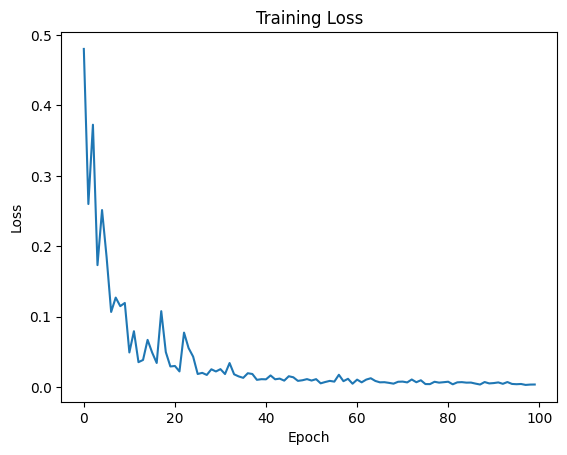

Test Loss: 0.0350


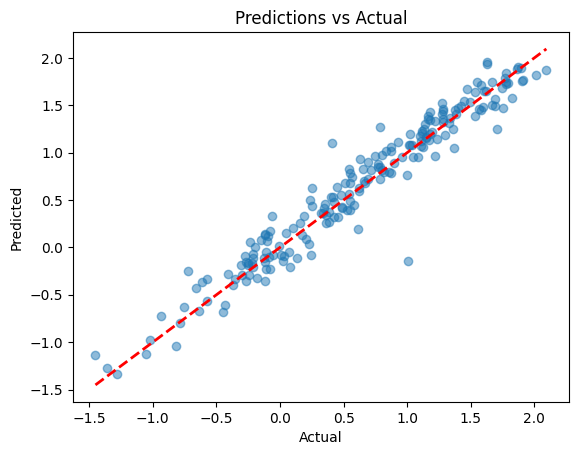

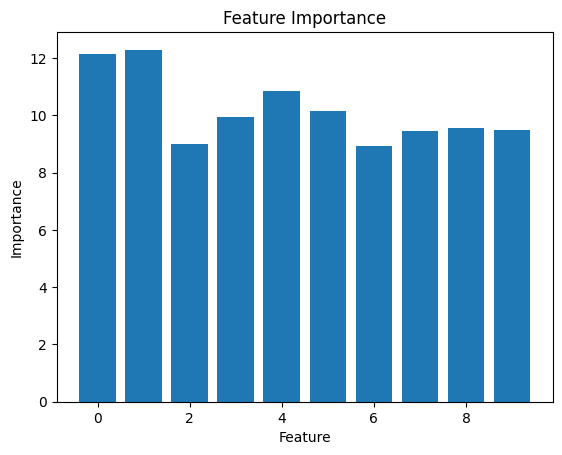

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate synthetic data
X = torch.randn(1000, 10)
y = torch.sin(X[:, 0]) + torch.cos(X[:, 1]) + torch.normal(0, 0.1, size=(1000,))

# Split data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the network and optimizer
net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot loss curve
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
net.eval()
with torch.no_grad():
    y_pred = net(X_test)
    test_loss = criterion(y_pred, y_test.unsqueeze(1))
    print(f'Test Loss: {test_loss.item():.4f}')

# Plot predictions vs actual
plt.scatter(y_test.numpy(), y_pred.numpy(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual')
plt.show()

# Feature importance analysis
importance = torch.abs(net.fc1.weight).sum(dim=0)
plt.bar(range(10), importance.detach().numpy())
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

# Initialize the network and optimizer
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

# Plot training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

# Evaluate the model
net.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = net(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = 100. * correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Visualize some predictions
net.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)

with torch.no_grad():
    outputs = net(images)

_, predicted = torch.max(outputs, 1)

# Plot the first 25 images
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f'Pred: {predicted[i]}, True: {labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize filters from the first convolutional layer
filters = net.conv1.weight.data.numpy()
plt.figure(figsize=(12, 6))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(filters[i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 9912422/9912422 [00:13<00:00, 730643.36it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████| 28881/28881 [00:00<00:00, 41876.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 1648877/1648877 [00:03<00:00, 437223.21it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 9097673.72it/s]
/home/raphael/admin_data_science_practice/venv/lib/python3.10/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/10], Loss: 0.2066, Accuracy: 93.70%


KeyboardInterrupt: 